In [1]:
suppressWarnings({library(rstan)
library(ggplot2)
library(dplyr)})

Caricamento del pacchetto richiesto: StanHeaders


rstan version 2.32.6 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)



Caricamento pacchetto: ‘dplyr’


I seguenti oggetti sono mascherati da ‘package:stats’:

    filter, lag


I seguenti oggetti sono mascherati da ‘package:base’:

    intersect, setdiff, setequal, union




## Ex 1: Quadratic Bayesian regression using STAN

The following n = 9 data sample
| X  |     Y       | σᵢ        |
|----|-------------|-----------|
|  2 |   105.5203  | 15.40459  |
|  3 |   227.4457  | 36.05480  |
|  4 |   405.6937  | 51.84040  |
|  5 |   661.2858  | 94.66744  |
|  6 |   886.1422  | 123.79828 |
|  7 |  1189.6514  | 216.99935 |
|  8 |  1631.8262  | 173.83507 |
|  9 |  1951.8381  | 318.46511 |
| 10 |  2528.5246  | 427.27788 |

is believed to follow
\begin{equation}
Y = \beta_0 + \beta_1 \cdot X + \beta_2 \cdot X^2
\end{equation}
Let the prior distributions for $\beta$ parameters be,
- $\beta_0$ normal distribution centered at 5 with a standard deviation of 1.
- $\beta_1$ uniform distribution between -1 and 1.
- $\beta_2$ normal distribution centered at 30 with a standard deviation of 15.

Build a Stan model and run a MCMC to obtain the posterior distribution of the $\beta$ parameters using also the σi uncertainty for each measurement.
1) Compute the 95% credibility interval for each β parameter.
2) Draw the fitted quadratic funtion (using the mean values of the $\beta$ parameters from MCMC) together with data points and their uncertainties.

In [2]:
X <- 2:10
Y <- c(105.5203, 227.4457, 405.6937, 661.2858, 886.1422,
       1189.6514, 1631.8262, 1951.8381, 2528.5246)
sigma <- c(15.40459, 36.05480, 51.84040, 94.66744, 123.79828,
           216.99935, 173.83507, 318.46511, 427.27788)
n <- length(X)

#### 1)

In [3]:
stan_data <- list(n = n, X = X, Y = Y, sigma = sigma)

stan_code <- "
data{
    int<lower=0> n;
    vector[n] X;
    vector[n] Y;
    vector<lower=0>[n] sigma;
}
parameters{
    real beta0;
    real<lower=-1, upper=1> beta1;
    real beta2;
}
model{
    beta0 ~ normal(5, 1);
    beta2 ~ normal(30, 15);
    for (i in 1:n){
        Y[i] ~ normal(beta0 + beta1 * X[i] + beta2 * square(X[i]), sigma[i]);
    }
}  "


In [4]:
fit <- stan(model_code = stan_code, data = stan_data,
            iter = 4000, warmup = 1000, chains = 4, seed = 123)
print(fit, probs = c(0.025, 0.975))


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 6e-06 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 4000 [  0%]  (Warmup)
Chain 1: Iteration:  400 / 4000 [ 10%]  (Warmup)
Chain 1: Iteration:  800 / 4000 [ 20%]  (Warmup)
Chain 1: Iteration: 1001 / 4000 [ 25%]  (Sampling)
Chain 1: Iteration: 1400 / 4000 [ 35%]  (Sampling)
Chain 1: Iteration: 1800 / 4000 [ 45%]  (Sampling)
Chain 1: Iteration: 2200 / 4000 [ 55%]  (Sampling)
Chain 1: Iteration: 2600 / 4000 [ 65%]  (Sampling)
Chain 1: Iteration: 3000 / 4000 [ 75%]  (Sampling)
Chain 1: Iteration: 3400 / 4000 [ 85%]  (Sampling)
Chain 1: Iteration: 3800 / 4000 [ 95%]  (Sampling)
Chain 1: Iteration: 4000 / 4000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.01 seconds (Warm-up)
Chain 1:                0.035 seconds (Sampling)
Chain 1:                0

In [5]:
post <- extract(fit)

beta0_mean <- mean(post$beta0)
beta1_mean <- mean(post$beta1)
beta2_mean <- mean(post$beta2)

x_grid <- seq(2, 10, length.out = 200)
y_pred <- beta0_mean + beta1_mean * x_grid + beta2_mean * x_grid ** 2

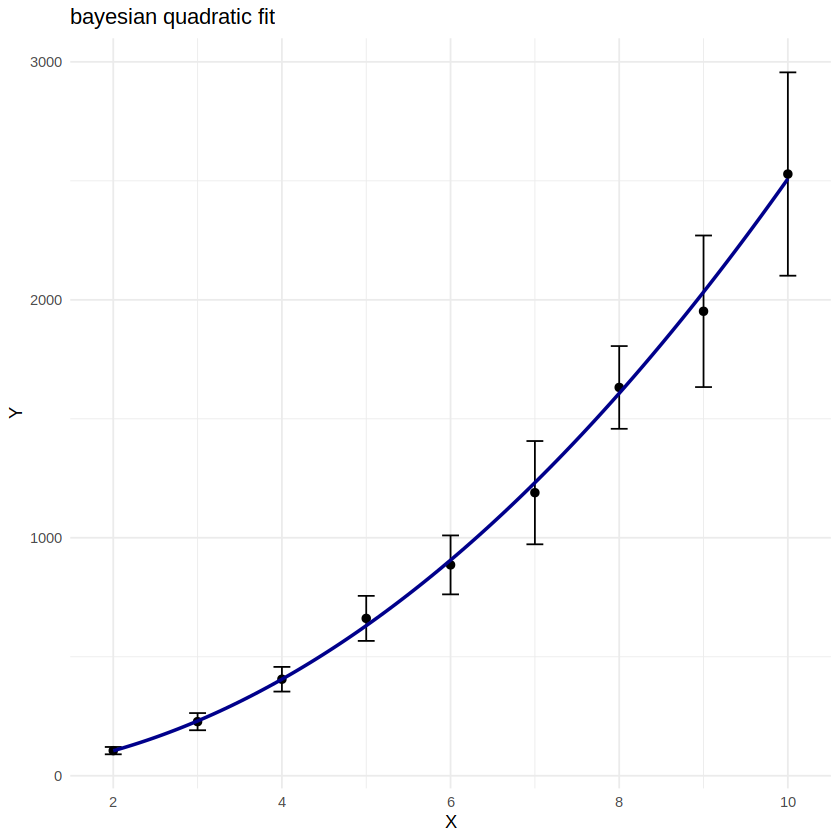

In [6]:
df <- data.frame(X, Y, sigma)
fit_df <- data.frame(x = x_grid, y = y_pred)

ggplot(df, aes(x = X, y = Y)) +
    geom_point(size = 2) +
    geom_errorbar(aes(ymin = Y - sigma, ymax = Y + sigma), width = 0.2) +
    geom_line(data = fit_df, aes(x = x, y = y), color = "darkblue", linewidth = 1) +
    labs(title = "bayesian quadratic fit",
         x = "X", y = "Y") +
    theme_minimal()

## Ex 2

A study on water quality of streams, a high level of bacter $X$ was defined as a level greater than $100$
per $100$ ml of stream water. $n = 115$ samples were taken from streams having a high environmental
impact on pandas. Out of these, $y = 10$ had a high bacter $X$ level.

Letting $p$ be the probability that a sample of water taken from the stream has a high bacter $X$ level,

1) Find the frequentist estimator for $p$.
2) Using a $\texttt{Beta}(1, 11)$ prior for $p$, calculate and posterior distribution $P(p|y)$.
3) Find the bayesian estimator for $p$, the posterior mean and variance, and a $95\%$ credible interval.
4) Test the hypothesis
\begin{equation}
H_{o} : p = 0.1 \quad\text{versus}\quad H_1 : p \neq 0.1
\end{equation}

at $5\%$ level of significance with both the frequentist and bayesian approach.

A new measurement, performed one month later on $n = 165$ water samples, gives $y = 9$ high bacter
$X$ level

5) Find the frequentist estimator for $p$.
6) Find a bayesian estimator for $p$, assuming both a $\texttt{Beta}(1, 10)$ prior for $p$, and assuming the posterior probability of the older measurement as the prior for the new one.
7) Find the bayesian estimator for $p$, the posterior mean and variance, and a $95\%$ credible interval.
8) Test the hypothesis

\begin{equation}
H_{o} : p = 0.1 \quad\text{versus}\quad H_1 : p \neq 0.1
\end{equation}

at $5\%$ level of significance with both the frequentist and bayesian approach.

In [7]:
n <- 115
y <- 10

#### 1)

In [8]:
p_freq <- y / n
cat("frequentist estimator =", y, "/", n, "=", round(p_freq, 4), "\n")

frequentist estimator = 10 / 115 = 0.087 


#### 2)

In [9]:
alpha_prior <- 1
beta_prior <- 11

alpha_post <- alpha_prior + y
beta_post <- beta_prior + n - y

cat("prior: beta(", alpha_prior, ",", beta_prior, ")\n")
cat("posterior: beta(", alpha_post, ",", beta_post, ")\n")
cat("P(p|y) ~ beta(", alpha_post, ",", beta_post, ")\n\n")

prior: beta( 1 , 11 )
posterior: beta( 11 , 116 )
P(p|y) ~ beta( 11 , 116 )



#### 3)

In [10]:
mean_post <- alpha_post / (alpha_post + beta_post)
var_post <- (alpha_post * beta_post) / ((alpha_post + beta_post) ** 2 * (alpha_post + beta_post + 1))

lower <- qbeta(0.025, alpha_post, beta_post)
upper <- qbeta(0.975, alpha_post, beta_post)

In [11]:
cat("posterior mean:", round(mean_post, 4), "\n")
cat("posterior variance:", round(var_post, 6), "\n")
cat("95% CI: [", round(lower, 4), ",", round(upper, 4), "]\n\n")

posterior mean: 0.0866 
posterior variance: 0.000618 
95% CI: [ 0.0444 , 0.1411 ]



#### 4)

In [12]:
#frequentis approach
p_0 <- 0.1

cat("H test: H0: p = 0.1 vs H1: p /= 0.1\n frequentist:")
p_value <- 2 * min(pbinom(y, n, p_0), 1 - pbinom(y-1, n, p_0))

cat("p-value:", round(p_value, 4), "\n")
cat(ifelse(p_value < 0.05, "reject H0", "non reject H0"), "\n")

#bayesian
reject <- ifelse(p_0 >= lower & p_0 <= upper, "non reject H0", "reject H0")
cat("\nbayesian:\n - 95% CI for p0 = 0.1:", reject)

H test: H0: p = 0.1 vs H1: p /= 0.1
 frequentist:p-value: 0.7854 
non reject H0 

bayesian:
 - 95% CI for p0 = 0.1: non reject H0

#### 5)

In [13]:
n_new <- 165 
y_new <- 9
p_freq_new <- y_new / n_new
cat("2nd dataset: \nfrequentist estimator =", y_new, "/", n_new, "=", round(p_freq_new, 4), "\n")

2nd dataset: 
frequentist estimator = 9 / 165 = 0.0545 


#### 6)

In [14]:
#prior beta(1,10)
alpha_prior_new <- 1
beta_prior_new <- 10

alpha_post_new <- alpha_prior_new + y_new
beta_post_new <- beta_prior_new + n_new - y_new

post_mean_new <- alpha_post_new / (alpha_post_new + beta_post_new)
cat("prior: beta(1,10)\nposterior: beta(", alpha_post_new, ",", beta_post_new, ")\n")
cat("bayesian estimator:", round(post_mean_new,4))

prior: beta(1,10)
posterior: beta( 10 , 166 )
bayesian estimator: 0.0568

In [15]:
#prior = posterior of previous data
alpha_post_new_prev_prior <- alpha_post + y_new 
beta_post_new_prev_prior <- beta_post + n_new - y_new 
post_mean_new_prev_prior <- alpha_post_new_prev_prior / (alpha_post_new_prev_prior + beta_post_new_prev_prior)

cat("prior: beta(", alpha_post, ",", beta_post, ")\n")
cat("posterior beta(", alpha_post_new_prev_prior, ",", beta_post_new_prev_prior, ")\n")
cat("beayesian estimaro:", round(post_mean_new_prev_prior, 4), "\n\n")

prior: beta( 11 , 116 )
posterior beta( 20 , 272 )
beayesian estimaro: 0.0685 



#### 7)

In [16]:
var_post_new_prev_prior <- (alpha_post_new_prev_prior * beta_post_new_prev_prior) / ((alpha_post_new_prev_prior + beta_post_new_prev_prior) ** 2 * (alpha_post_new_prev_prior + beta_post_new_prev_prior + 1))

lower_new <- qbeta(0.025, alpha_post_new_prev_prior, beta_post_new_prev_prior)
upper_new <- qbeta(0.975, alpha_post_new_prev_prior, beta_post_new_prev_prior)

cat("posterior mean:", round(post_mean_new_prev_prior, 4), "\n")
cat("posterior variance:", round(var_post_new_prev_prior, 6), "\n")
cat("95% CI: [", round(lower_new, 4), ",", round(upper_new, 4), "]\n\n")

posterior mean: 0.0685 
posterior variance: 0.000218 
95% CI: [ 0.0425 , 0.1001 ]



#### 8)

In [17]:
cat("H test: H0: p = 0.1 vs H1: p /= 0.1:\n")
p_value_freq_new <- 2 * min(pbinom(y_new, n_new, p_0), 1 - pbinom(y_new-1, n_new, p_0))

#frequentist
cat("\nfrequentist:\n")
cat("- p-value =", round(p_value_freq_new, 4), "\n")
cat(ifelse(p_value_freq_new < 0.05, "reject H0", "non reject H0"), "\n")

#bayesian
bayesian_test <- ifelse(p_0 >= lower_new & p_0 <= upper_new, "non reject H0", "reject H0")

cat("\nbayesian:\n")
cat("p_0 in CI = 95%:", bayesian_test)

H test: H0: p = 0.1 vs H1: p /= 0.1:

frequentist:
- p-value = 0.0549 
non reject H0 

bayesian:
p_0 in CI = 95%: non reject H0

## Ex 3

Analyze the data of Exercise 2 and solve points (2) and (3) building and running a MCMC using Stan.

In [18]:
stan_model <- "
data{
    int<lower=0> n; 
    int<lower=0> y;
    real<lower=0> alpha_prior;
    real<lower=0> beta_prior;
}
parameters{
    real<lower=0,upper=1> p;
}
model{
    p ~ beta(alpha_prior, beta_prior); 
    y ~ binomial(n, p);
}"

In [19]:
stan_data <- list(n = n_new, y = y_new,
                alpha_prior = alpha_post,
                beta_prior = beta_post)

fit <- stan(model_code = stan_model,
            data = stan_data,
            iter = 4000, warmup = 1000,
            chains = 4, seed = 87035)

print(fit, pars = "p", probs = c(0.025, 0.975))

ERROR: Error in compileCode(f, code, language = language, verbose = verbose): /home/teobaldo/miniconda3/envs/ragain/lib/R/library/RcppEigen/include/Eigen/src/Core/ProductEvaluators.h:35:90:   required from 'Eigen::internal::evaluator<Eigen::Product<Lhs, Rhs, Option> >::evaluator(const XprType&) [with Lhs = Eigen::Product<Eigen::CwiseBinaryOp<Eigen::internal::scalar_product_op<double, double>, const Eigen::CwiseNullaryOp<Eigen::internal::scalar_constant_op<double>, const Eigen::Matrix<double, 1, -1> >, const Eigen::Transpose<Eigen::Matrix<double, -1, 1> > >, Eigen::Matrix<double, -1, -1>, 0>; Rhs = Eigen::Matrix<double, -1, 1>; int Options = 0; Eigen::internal::evaluator<Eigen::Product<Lhs, Rhs, Option> >::XprType = Eigen::Product<Eigen::Product<Eigen::CwiseBinaryOp<Eigen::internal::scalar_product_op<double, double>, const Eigen::CwiseNullaryOp<Eigen::internal::scalar_constant_op<double>, const Eigen::Matrix<double, 1, -1> >, const Eigen::Transpose<Eigen::Matrix<double, -1, 1> > >, Eigen::Matrix<double, -1, -1>, 0>, Eigen::Matrix<double, -1, 1>, 0>]'/home/teobaldo/miniconda3/envs/ragain/lib/R/library/RcppEigen/include/Eigen/src/Core/Product.h:132:22:   required from 'Eigen::internal::dense_product_base<Lhs, Rhs, Option, 6>::operator const Scalar() const [with Lhs = Eigen::Product<Eigen::CwiseBinaryOp<Eigen::internal::scalar_product_op<double, double>, const Eigen::CwiseNullaryOp<Eigen::internal::scalar_constant_op<double>, const Eigen::Matrix<double, 1, -1> >, const Eigen::Transpose<Eigen::Matrix<double, -1, 1> > >, Eigen::Matrix<double, -1, -1>, 0>; Rhs = Eigen::Matrix<double, -1, 1>; int Option = 0; Eigen::internal::dense_product_base<Lhs, Rhs, Option, 6>::Scalar = double]'/home/teobaldo/miniconda3/envs/ragain/lib/R/library/StanHeaders/include/src/stan/mcmc/hmc/hamiltonians/dense_e_metric.hpp:22:56:   required from 'double stan::mcmc::dense_e_metric<Model, BaseRNG>::T(stan::mcmc::dense_e_point&) [with Model = model6c936a56b1ba__namespace::model6c936a56b1ba_; BaseRNG = boost::random::additive_combine_engine<boost::random::linear_congruential_engine<unsigned int, 40014, 0, 2147483563>, boost::random::linear_congruential_engine<unsigned int, 40692, 0, 2147483399> >]'/home/teobaldo/miniconda3/envs/ragain/lib/R/library/StanHeaders/include/src/stan/mcmc/hmc/hamiltonians/dense_e_metric.hpp:21:10:   required from here/home/teobaldo/miniconda3/envs/ragain/lib/R/library/RcppEigen/include/Eigen/src/Core/DenseCoeffsBase.h:55:30: warning: ignoring attributes on template argument 'Eigen::internal::packet_traits<double>::type' {aka '__m128d'} [-Wignored-attributes]make: *** [/home/teobaldo/miniconda3/envs/ragain/lib/R/etc/Makeconf:200: file6c9353f4856a.o] Interruzione


ERROR: Error in sink(type = "output"): connessione non valida


In [ ]:
samples <- extract(fit)$p

# mean, var posterior
mean <- mean(samples)
var <- var(samples)
CI <- quantile(samples, probs = c(0.025, 0.975))

cat("posterior mean:", round(mean, 4))
cat("\nposterior variance:", round(var, 6))
cat("\n95% CI:", round(CI[1], 4), "-", round(CI[2], 4))

posterior mean: 0.0684
posterior variance: 0.000219
95% CI: 0.0422 - 0.1